### Coin-flipping example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/albazarova/sbi_intro/blob/main/notebooks/sbi_intro_for_colab.ipynb)

Suppose, naively, that you are unsure about the probability of heads in a coin flip (spoiler alert: it's 50 \%). You believe there is some true underlying ratio, call it $p$, but have no prior opinion on what $p$ might be.

We begin to flip a coin, and record the observations: either $H$ or $T$. This is our observed data. An interesting question to ask is how our inference changes as we observe more and more data? More specifically, what do our posterior probabilities look like when we have little data, versus when we have lots of data.

Below we plot a sequence of updating posterior probabilities as we observe increasing amounts of data (coin flips).

In [ ]:
def setup_colab_environment():
    '''Install requirements to run sbi_intro tutorial on colab notebooks.
    Takes some time. It's possible to opt to install packaged on demand too.'''
    !pip install -r https://raw.githubusercontent.com/albazarova/sbi_intro/refs/heads/main/ray_cluster/requirements.txt
    
# setup_colab_environment()

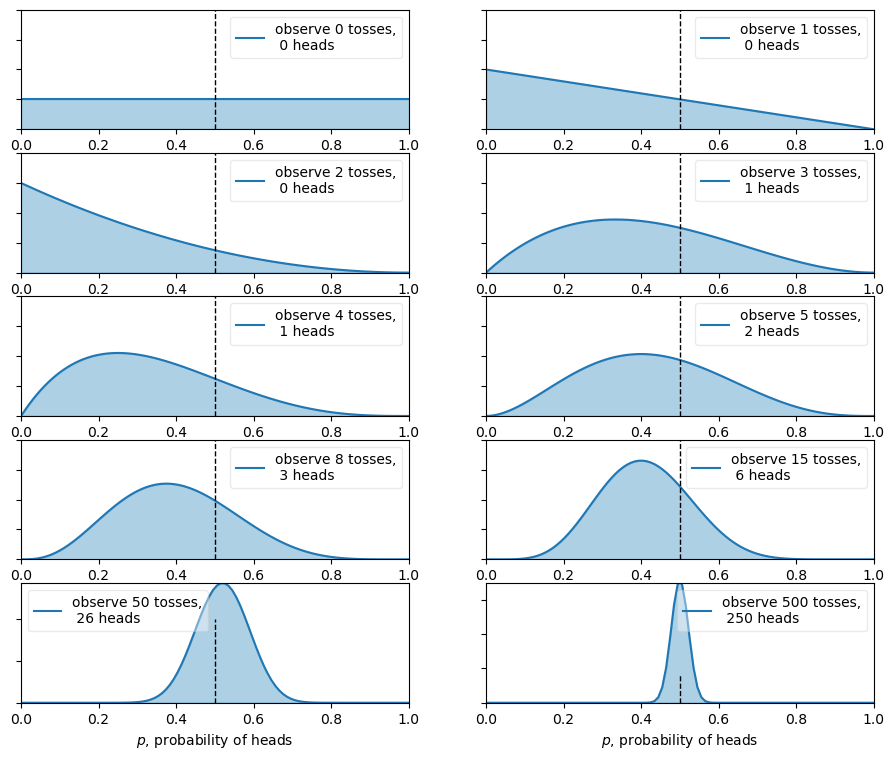

In [9]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

import scipy.stats as stats

dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0, 1, 100)

# # For the already prepared, I'm using Binomial's conj. prior.
for k, N in enumerate(n_trials):
    sx = plt.subplot(int(len(n_trials) / 2), 2, k + 1)
    plt.xlabel("$p$, probability of heads") 
    #if k in [0, len(n_trials) - 1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1 + heads, 1 + N - heads) #by varuing parameters of the beta distribution we can see how prior influences posterior
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)

### Transferring into SBI framework

Clearly, this was a very simple example of Bayesian inference, where the posterior distribution was explicitly derived and hence there is no real need to use neither the sampling methods nor simulation based inference. Nevertheless, for the sake of understanding, how it can be transferred into the simulation based learning framework, we will repeat our inference (or at least a part of it) using the sbi package

For that we create a simulatior with one distribution parameter which simulates Bernoulli trials. We pre-define the number of trials $N=50$ and specify a uniform prior on the $(0,1)$ interval.

In [ ]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import infer

N=50
def simulator(p):    
    return torch.tensor(stats.bernoulli.rvs(p, size=N))
    
prior=utils.BoxUniform(low=torch.tensor([0.01]),high=torch.tensor([0.99]))    


Now we need to generate simulations given our prior, simulator and infer the approximate posterior distribution. We will use here the simplest method of inference SNPE, which infers the whole posterior distribution given the samples from the simulator by means of a normalizing flow, and does not require any further sampling algorithm afterwards.

In [18]:
posterior = infer(simulator, prior, method="SNPE", num_simulations=10000)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.: 100%|██████████| 10000/10000 [00:01<00:00, 8263.08it/s]
/p/project/training2405/sc_venv_sbi_local/venv/lib/python3.11/site-packages/sbi/neural_nets/flow.py:165: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel, y_numel = get_numel(batch_x, batch_y, embedding_net)


 Neural network successfully converged after 103 epochs.

Now let us pass an observation to our model with the idea of inferring the distribution parameter $p$. We use the same data as previously, when running the classical Bayesian inference. Note, that if we want to change $N$, the posterior inference has to be  run all over again.

We then draw samples from the posterior in order t be able to plot the distribution of the parameter $p$

One can easily change the inference method SNPE to SNRE or SNLE and see, how this saffects the results and their confidences. Also note, that since for SNLE and SNRE an actual MCMC algorithm has to be run, it takes longer time to sample froma posterior in thjose case.


In [19]:
observation=data[:N]
samples = posterior.sample((10000,), x=observation)


Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 17851.34it/s]


We now plot the resulting distribution together with the true value of the parameter (which is obviously 0.5). We can immediately see that the overall shape and skewness of the distribution with respect to the true value of the parameter is similar to the one we obtained before using classical inference. However, obviously, the spread of the distrbution is wider in the SBI case.

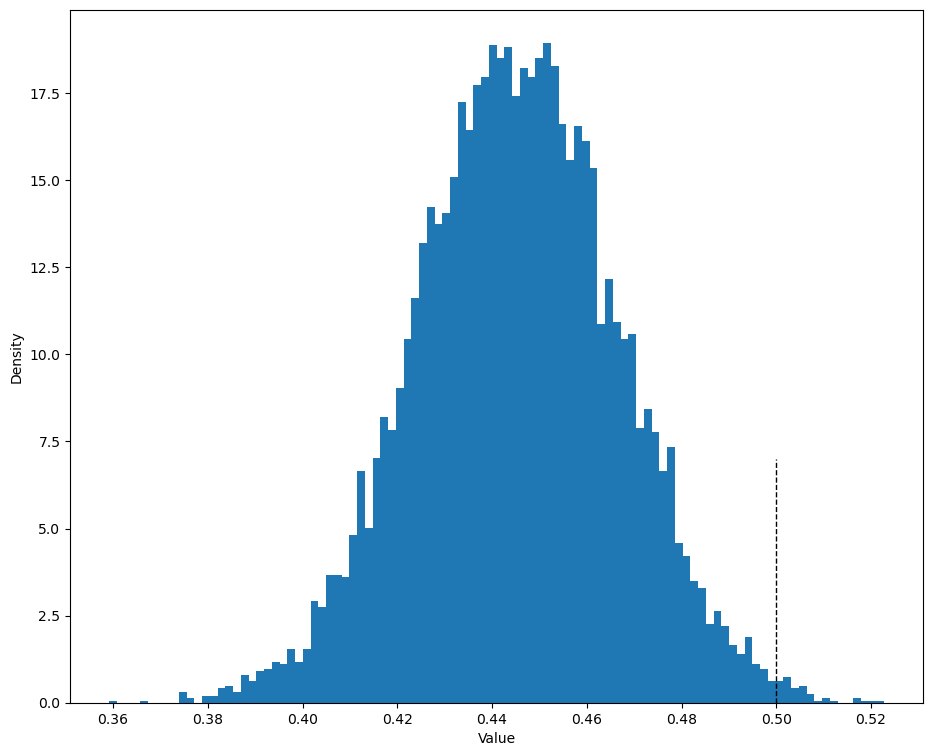

In [20]:
plt.hist(samples.numpy(), bins=100, density=True)
plt.vlines(0.5, 0, 7, color="k", linestyles="--", lw=1)
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

##### Inferring behaviour from text-message data

Let's try to model a more interesting example, one that concerns the rate at which a user sends and receives text messages:

>  You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddenly. How can you model this? 

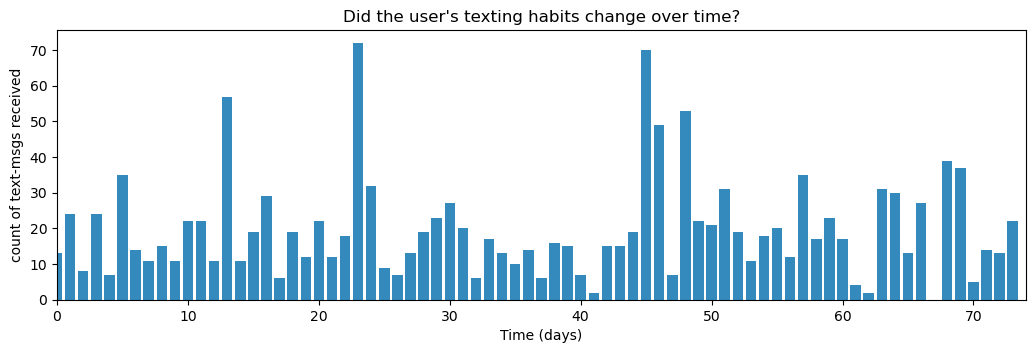

In [ ]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt


figsize(12.5, 3.5)
count_data = np.loadtxt("https://raw.githubusercontent.com/albazarova/sbi_intro/refs/heads/main/data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)
plt.show()

Poisson random variable would be a very appropriate model for this type of *count* data. Denoting day $i$'s text-message count by $C_i$, 

$$ C_i \sim \text{Poisson}(\lambda)  $$

We are not sure what the value of the $\lambda$ parameter really is, however. Looking at the chart above, it appears that the rate might become higher late in the observation period, which is equivalent to saying that $\lambda$ increases at some point during the observations. (Recall that a higher value of $\lambda$ assigns more probability to larger outcomes. That is, there is a higher probability of many text messages having been sent on a given day.)

How can we represent this observation mathematically? Let's assume that on some day during the observation period (call it $\tau$), the parameter $\lambda$ suddenly jumps to a higher value. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a *change-point*:

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$


If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.

We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? Recall that $\lambda$ can be any positive number. As we saw earlier, the *exponential* distribution provides a continuous density function for positive numbers, so it might be a good choice for modeling $\lambda_i$. But recall that the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $\alpha$.

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}

$\alpha$ is called a *hyper-parameter* or *parent variable*. In literal terms, it is a parameter that influences other parameters. Our initial guess at $\alpha$ does not influence the model too strongly, so we have some flexibility in our choice.  A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we're modeling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 


What about $\tau$? Because of the noisiness of the data, it's difficult to pick out a priori when $\tau$ might have occurred. Instead, we can assign a *uniform prior belief* to every possible day. This is equivalent to saying

\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}

Given all the information above combined with the Bayes rule we can rigorously derive overall prior distribution of the parameters as well as the likelihood, however given that this course concentrates more on deploying Bayesian models rather than on mathematical aspects of them we will omit this part in order to save time and turn immediately to PyMC, a Python library for performing Bayesian analysis.


The below code for MCMC inference is written in PyMC. Studying PyMC is not within the scope of this course and we use MCMC here exclusively for illustrating purposes and for results comparison. Therefore, we are not discussing the code here.

The code below sets up an MCMC sampling method with parameters ($\tau, \lambda_1, \lambda_2$ )


In [2]:
#!pip install pymc
import pymc as pm

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    #tau = pm.DiscreteUniform("tau", lower=0, upper=44)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data-1)

In [3]:
with model:
    #idx = np.arange(n_count_data) # Index
    idx=np.arange(n_count_data)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [4]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [5]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(20000, tune=5000, step=step,
                      return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [tau]


/p/project/training2405/sc_venv_sbi_local/venv/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 5_000 tune and 20_000 draw iterations (20_000 + 80_000 draws total) took 210 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Finally we can extract the results of the MCMC and plot the parameter distributions

In [17]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']
lambda_1_samples

array([17.62177069, 18.1225428 , 18.1225428 , ..., 17.361473  ,
       17.361473  , 17.361473  ])

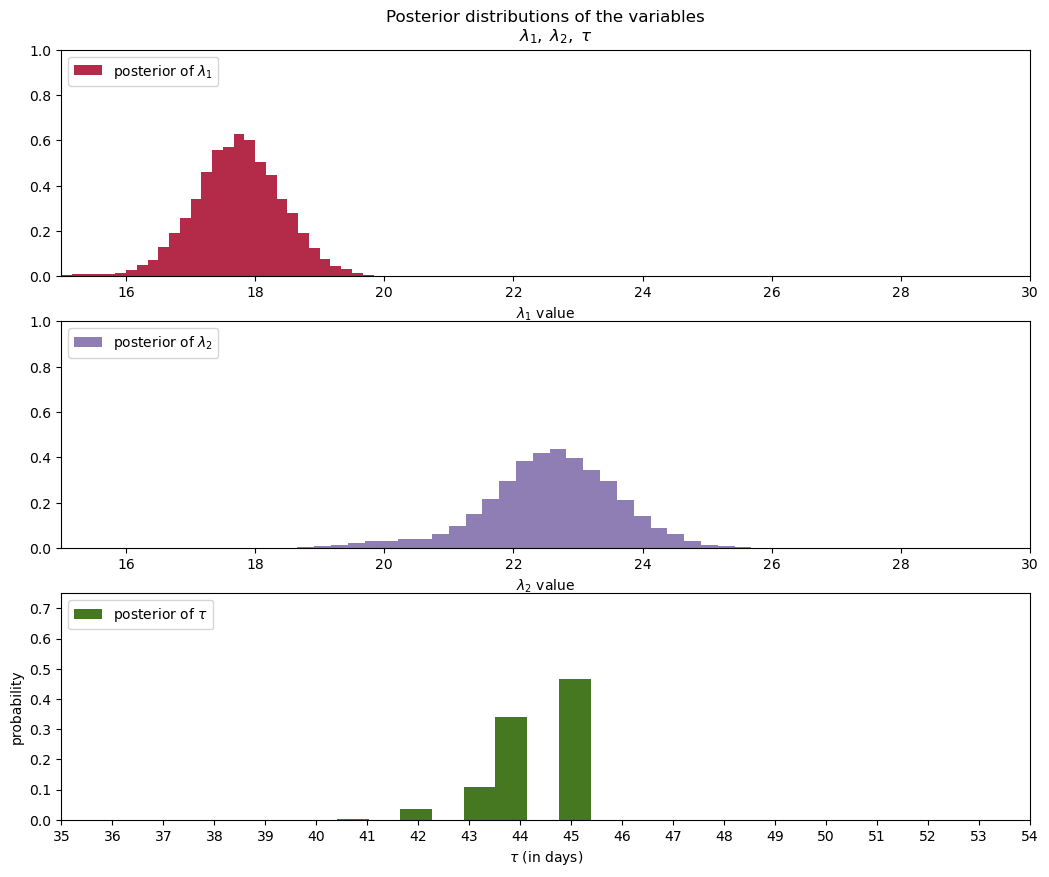

In [ ]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
bins = np.linspace(15, 20, 31)

plt.hist(lambda_1_samples, histtype='stepfilled',
          bins=bins, alpha=0.85, 
          label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability")
plt.show()

Let us now visualise the average number of text messages expected on a certain day. In the code below, let $i$ index samples from the posterior distributions. Given a day $t$, we average over all possible $\lambda_i$ for that day $t$, using $\lambda_i = \lambda_{1,i}$ if $t \lt \tau_i$ (that is, if the behaviour change has not yet occurred), else we use $\lambda_i = \lambda_{2,i}$. 

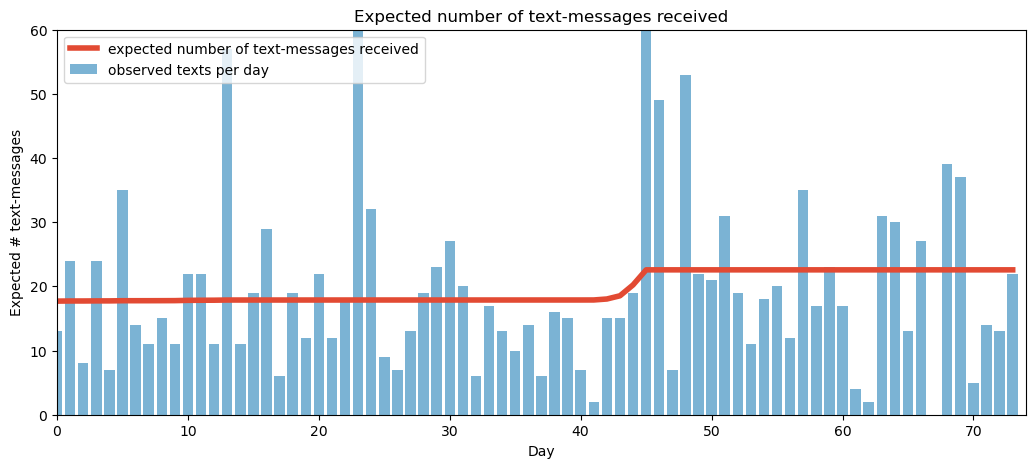

In [ ]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left")
plt.show()

### Putting the model into SBI framework

Firstly we would need to write down a simulator function dependent on the parameters from the above: $(\tau,\lambda_1,\lambda_2)$. We fix the parameter $\alpha=\frac1{20}$, and as for the priors, we keep them to be as before using function `MultipleIndependent` to combine different probability distributions.

Note, that all the distributions either need to belong to `sbi` package or `torch.distributions`, and the parameters of the distributions have to be defined as `torch.Tensors`


In [ ]:
import torch
from sbi.utils import MultipleIndependent
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import infer
import numpy as np
import scipy.stats as stats



def simulator(params):
        data = np.r_[stats.poisson.rvs(mu=params[0], size=int(params[2])), stats.poisson.rvs(mu=params[1], size=74 - int(params[2]))]
        return data
    

alpha=1./20.    
prior=MultipleIndependent(
    [
        torch.distributions.Exponential(rate=torch.ones(1)*0.05),
        torch.distributions.Exponential(rate=torch.ones(1)*0.05),
        torch.distributions.Uniform(low=torch.Tensor([30]),high=torch.Tensor([60]))
    ]
)
        

/p/software/jusuf/stages/2024/software/tqdm/4.66.1-GCCcore-12.3.0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-29 09:47:52,924	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Let us infer the variable `posterior` which is going to correspond to posterior distribution in case we use SNPE method. One can replace SNPE by SNRE and observe that the training runs way faster. However, sampling from the posterior would take way more time since it actually requires calling the sampling algorithm.

In [25]:
import numpy as np
posterior = infer(simulator, prior, method="SNPE", num_simulations=10000)

Running 10000 simulations.: 100%|██████████| 10000/10000 [00:01<00:00, 5395.19it/s]


 Neural network successfully converged after 111 epochs.

Use the above observation to sample from the posterior distribution

In [ ]:
observation=np.loadtxt("https://raw.githubusercontent.com/albazarova/sbi_intro/refs/heads/main/data/txtdata.csv")

#observation=observation
samples = posterior.sample((10000,), x=observation)

Drawing 10000 posterior samples: 10017it [00:14, 675.52it/s]                          


Plot the distributions of the parameters $\lambda_1$, $\lambda_2$, $\tau$

/tmp/ipykernel_9636/263924401.py:4: DeprecationWarning: **kwargs are deprecated, use fig_kwargs instead. 
               Calling the to be deprecated pairplot function
  fig, out = pairplot(samples, limits=[[0,30],[0,30],[0,70]], fig_size=(3,3), upper='kde', diag='kde')


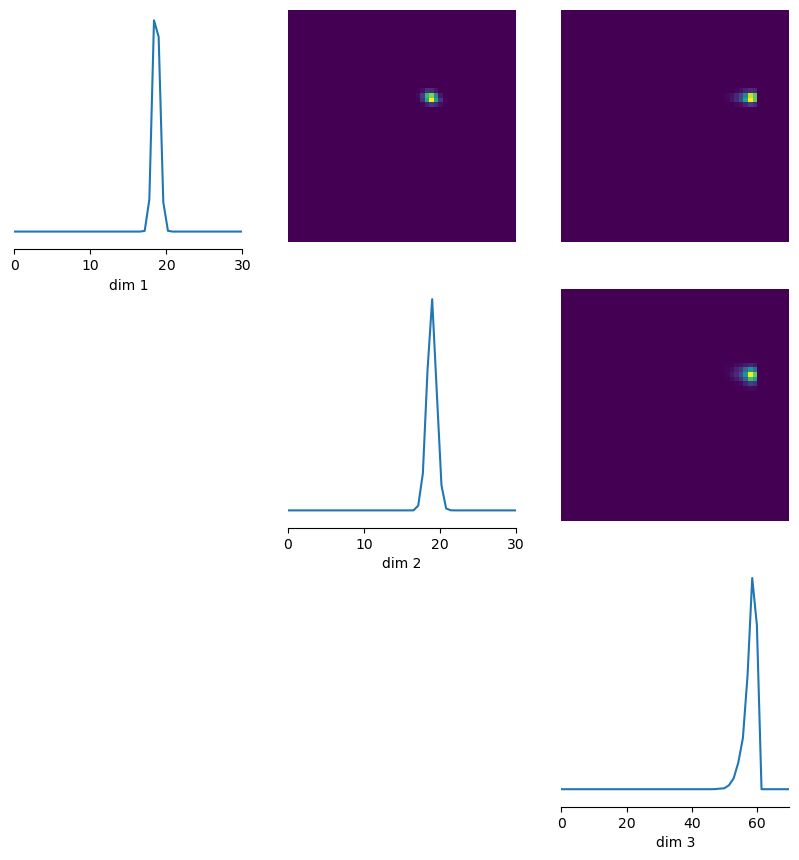

In [ ]:
%matplotlib inline
from sbi.analysis.plot import pairplot

fig, out = pairplot(samples, limits=[[0,30],[0,30],[0,70]], fig_kwargs={'fig_size':(3,3)}, upper='kde', diag='kde')


Clearly, the results of the above inference look very different from what we have obtained previsously with an MCMC method. As previously, we visualise the expected number of text messages a day and display it on a graph. We see that the above inference has certain grounds too, especially given the absence of ground truth in this case. However, this raises a question of whether the prior we chose for the SBI model was good enough and whether the number of simulation was sufficient.

Note that in all cases here we were using the amortized neural inference, meaning that we used exclusively simulations to build up an approximation for posterior/likelihood/likelihood ratio. This means that we can easily run inference on a different observation and get different values of the parameters without re-running the whole inference. On the other hand, we are obviously not restricted to feeding only one observation to our inference. Therefore, we can run inference on arbitrarily many available observations.

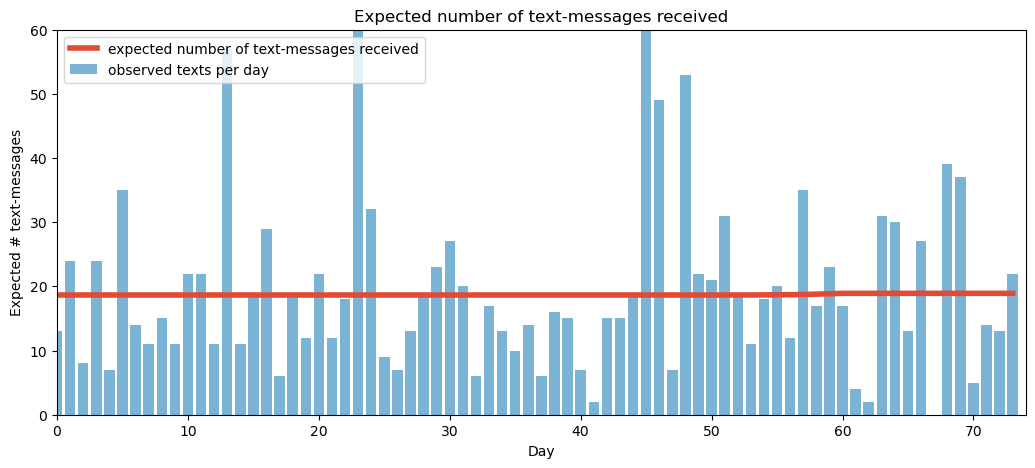

In [ ]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < samples[:,2]
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (samples[ix,0].sum()
                                   + samples[~ix,1].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left")
plt.show()

## Flexible inference

Previously we have shown a couple of examples of how to use `sbi` package as a one-liner. Here we are going to discuss he flexible inference of the package, which might be useful for customizing the code to fit a particular problem

Within this block we are going to discuss:

- performing sequential posterior estimation by focusing on a particular observation over multiple rounds. This can decrease the number of simulations one has to run, but the inference procedure is no longer amortized .    
- possibly specify your own density estimator, or change hyperparameters of existing ones (e.g. number of hidden units for [NSF](https://arxiv.org/abs/1906.04032)).    
- methods of crafting summary statistics instead of using the whole simulation as an input to neural network
- parallelisation over multiple workers on the same node or multiple nodes

## Real Life example

Below is actually a very basic example from my own research. This is an epidemiological model of the first 70 days of the COVID-19 pandemic starting from the beginning of March until the end of May and is a good illustration of how summary statistic can influence the inference results.

We will implement a version of SEIR model (Susceptible-Exposed-Infected-Recovered) and will use `pyross` package for that

We do the necessary imports first

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pyross
import torch
from sbi.analysis.plot import pairplot
from sbi.inference import SNPE, simulate_for_sbi
import sbi.utils as utils

/p/software/jusuf/stages/2024/software/tqdm/4.66.1-GCCcore-12.3.0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-06 22:21:31,441	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## RKI data

Again, not to overload our example with additional RKI software we pass the pre-downloaded RKI data on the incidence rates as a dicitonary. Further on, we pass it to the class `CaseData` defined above and get the input ready for SBI implementation.

In [ ]:
data= pd.read_csv("https://raw.githubusercontent.com/albazarova/sbi_intro/refs/heads/main/data/RKI_data.csv")
data

In [ ]:
data.plot(x="Date", y=['Confirmed', 'Deaths', 'Recovered'])
plt.show()

## The SEIR model and the simulator

The simulator below is implementing the following SEIR model

$
\frac{dS}{dt}=-\beta SI
$

$
\frac{dE}{dt}= \beta SI - \alpha E
$

$
\frac{dI}{dt}= \alpha E -\gamma I
$

$
\frac{dR}{dt}= \gamma I
$

$S+E+I+R=N$

$
\beta = 
\begin{cases} 
\beta_1 & \text{if } t<T \\
\beta_2 & \text{if } t\geq T \\
\end{cases}
$

Here, $S$ the number of people susceptible to the infection in the population on day $t$, $E$ the number of people exposed to the virus on day $t$, $I$ the number of people who has the infection on day $t$, $R$ is the number of people who recovered from the infection as of day $t$

Parameter $\beta$ is the infection rate. Note, that we are modeling a change-point at timepoint $T=18$. This way we are taking into account massive non-pharmaceutical interventions which were undertaken around March, 18, 2020. This corresponds to variables `beta`, `beta_1`, `beta_2` in the code.

Parameter $\alpha$ (`gE` in the code) is the transition rate from Exposed to Infected. This is the unobserved parameter and in our code for simplicity it is set to a constant $0.85$.

Parameter $\gamma$ (`gI` in the code) is the recovery rate. 

All the compartments sum up to the total population $N$ which we assume to be $10^6$ in the simulator below.

Importantly, to make our system of ODE complete, we need to pass the initial values for the compartments $S$, $E$, $I$, $R$, which are $S_0$, $E_0$, $I_0$, $R_0$ respectovely. Our simulator assumes fixed values for each one of them, but of course, especially those for unobserved compartments such as $E$ and partly $S$, can also be passed as parameters of the model. 

## Parametrisation

Note that our simulator has three parameters related to infection rate and recovery rate. However, the parametrisation is not exactly straightforward. Since SBI is learning from the large number of the unconstrained simulations, we want to utilise all the prior information available. This, being dependence between parameters $\beta_1$, $\beta_2$ and $\gamma$. 

Firstly, given that on March 18, 2020 there was a non-pharmaceutica intervention, seriously limiting contacts between people, we expect that infection rate $\beta_2$ should most likely be smaller than $\beta_1$. Therefore, while the simulator function `simulator2` takes $\beta_1$ as the first parameter, the second parameter is modelling the difference between $\beta_2$ and $\beta_1$, at the same time not allowing $\beta_2$ to become negative. 

We apply a similar procedure to the recovery rate. Given the need for a non-pharmaceutical intervention, we assume that the recovery rate $\gamma$ was most likely lower than the initial infection rate $\beta_1$ and, again, the third parameter of the simulator is modelling the difference between $\gamma$ and $\beta_1$ in a similar fashion to the precious case. 

## Pyross package

Package `pyross` is a specific package for simulating epidemiological scenarios through compartmental models (https://pyross.readthedocs.io/en/latest/). It provides an easy interface of specifying our $SEIR$ model given the parameters and adding some randomness to it.

## Data

Importantly, if we intend to fit our model to the observed data, we need to make sure that the output of the simulator conceptually corresponds to the RKI data we have just downloaded. Given the parameters $\beta_1$, $\beta_2$, $\alpha$, $\gamma$, $S_0$, $E_0$, $I_0$, $R_0$ (or $N$), the output of the model will be the trajectories of $S$, $E$, $I$, $R$ over the specified time period.

However, unfortunately, the RKI data do not exactly correspond to any one of these compartments. The most objective data we have if daily "Daily confirmed infections", which is essentially the number of the individuals who were in the infected compartment at any point up to this particular date. Therefore, in order for our simulator to output exactly the data corresponding to our real data, we need to sum up the Infected and Recovered compartments (all people who are infected now and were before). You can see this being performed as the final step within the `simulator2` function

In [ ]:
def simulator2(parameters):
    M = 1  # the population has one age group
    N = 1e6  # and this is the total population
    Ni = N * np.ones(M)

    parameters=parameters.reshape((3,))

    beta1 = np.array(parameters[0])  # initial infection rate

    beta2 = np.max((beta1+np.array(parameters[1]),0.0001)) # infection rate after an NPI

    gE = 0.85  # transition from E to I

    gI = np.max((beta1+np.array(parameters[2]),0.0001)) # recovery rate 

    # set up initial conditions

    E0 = 3000 
    I0 = 1900
    R0 = 0
    S0 = N - (E0 + I0 + R0)

    #for pyross

    x0 = {"S": [S0], "E": [E0], "I": [I0], "R": [R0]}

    Tf = 70  # time span of our model
    Nf = Tf + 1

    # set the contact structure
    def contactMatrix(t):
        # C_ij = number of people group from group i that an individual from group j meets per day
        C=np.eye(M)
        return C


    #pyross model specification

    parameters = {"beta1": beta1,"beta2":beta2, "gE": gE, "gI": gI}
    true_parameters = {"beta1": beta1,"beta2":beta2, "gE": gE, "gI": gI}


    model_spec = {
        "classes": ["S", "E", "I", "R"],
        "S": {
            "infection": [["I", "S", "-beta"]],
        },
        "E": {"linear": [["E", "-gE"]], "infection": [["I", "S", "beta"]]},
        "I": {
            "linear": [
                ["E", "gE"],
                ["I", "-gI"],
            ],
        },
        "R": {
            "linear": [["I", "gI"]],
        },
    }

    # define time dependent parameters, in our case beta, which takes value beta1 before timepoint T and beta2 after timepoint T

    def parameter_mapping(input_parameters, t):
        output_parameters = {
            'gE' : input_parameters['gE'] ,
            'gI' : input_parameters['gI'] 
        }
        if t<18:
            output_parameters['beta'] = input_parameters['beta1']
        else:
            output_parameters['beta'] = input_parameters['beta2']
        return output_parameters


    # generating stochastic trajectory with pyross

    sto_model = pyross.stochastic.Model(model_spec, true_parameters, M, Ni,time_dep_param_mapping=parameter_mapping)

    # simulate model

    data = sto_model.simulate(x0, contactMatrix, Tf, Nf, method="tau-leaping")
    
    # record the outputs

    data_array = data["X"]

    # make the outputs look similar to the observed data

    data_array=data_array[:,2]+data_array[:,3]

    data_array=torch.from_numpy(data_array)

    return data_array

## Specifying the prior distributions

We use uniform distributions as our priors and specify their ranges according to the assumptions on $\beta_1$ and $\gamma$ discussed previously. Since the second and the third parameters model the difference between $\beta_2$ and $\beta_1$, and $\gamma$ and $\beta_1$, the corresponding ranges of the Uniform distributions are biased towards negative values, although we certainly allow a possibility of those differences being positive as well.

`BoxUniform` prior is a built-in function of the `sbi` package, but there is also a possibility of using `torch.distributions` family using `MultipleIndependent` wrapper. An example of such usage is given in `notebook_3_flexible_interface` within this repository.

In [ ]:
lower_limits_prior = torch.tensor([0.8,-0.3,-0.3])
upper_limits_prior = torch.tensor([1.5, 0.1,0.1])
prior_cpu = utils.BoxUniform(
    low=lower_limits_prior,
    high=upper_limits_prior
)

There are auxiliary functions which are supposed to make sure the components of the SBI have the appropriate format. We will omit them for now

In [6]:
# prior, num_parameters, prior_returns_numpy = process_prior(prior_cpu)
# simulator = process_simulator(simulator2, prior_cpu, prior_returns_numpy)
# check_sbi_inputs(simulator, prior_cpu)

### Putting priors on the correct devices

We will need to run the simulations on the CPU, whilst the neural network training is going to be done on the GPU, if available. For this we will create another instance of prior, `prior_gpu`.

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    prior_gpu=utils.BoxUniform(
    low=torch.tensor([0.8,-0.3,-0.3],device=device),
    high=torch.tensor([1.5,0.1,0.1],device=device)
)
    prior=prior_gpu
else:
    device = torch.device('cpu')
    prior=prior_cpu

/p/project/training2405/sc_venv_sbi_local/venv/lib/python3.11/site-packages/sbi/utils/torchutils.py:324: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  device = process_device(device)


## Instantiating the inference object

In order instantiate the inference object call one of the functions `SNPE`, `SNRE`, `SNLE` from `sbi.inference`.

 Note, that we can also customize the density estimator, namely the neural network used to build an approximate posterior/likelihood/likelihood ratio. More information on the available networks can be found in `sbi/utils/get_nn_models.py`. It is also possible to implement your own density estimator from scratch, e.g., including embedding nets to preprocess data, or to a density estimator architecture of your choice. 

For this, the `density_estimator` argument needs to be a function that takes `theta` and `x` batches as arguments to then construct the density estimator after the first set of simulations was generated.

The default value for the `density_estimator` is `maf`, whic h corresponds to Masked Autoregressive Flow, a normalizing flow which models the target distribution density as a product of conditional distribution densities $p(x_i|x_{1:i-1})$, where $\{x_i\}_{i=1}^n$ are the variables (hence autoregressive). MAF is applies linear transformations to the variables.

Certainly, there is an option of replacing the default value `maf` (mean autoregressiv flow) for `density_estimator` with `nsf` (neural spline flow). Neural Spline Flow, unlike MAF is a flow which performs non-linear (quadratic) transformations over variables. It takes longer to train such a network, and it is not always beneficial.

You can uncomment the line where `SNPE` explicitly specifies `density_estimator` and see for yourself, how the inference changes. Spoiler: in this particular example training drastically slows down, and the inferred posterior turns out to be a rather poor fit for the data, as will be seen from the posterior sampling procedure.

Going into finer details there is also an option of configuring the density estimator choosing the number of hidden features, transforms etc.  More details on hyperparameters can be found at `sbi/neural_nets` 
`

In [ ]:
from sbi.neural_nets import posterior_nn # For SNLE: likelihood_nn(). For SNRE: classifier_nn()

density_estimator_build_fun = posterior_nn(
    model="nsf", hidden_features=30, num_transforms=4
)

#inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun,device=device)

inference=SNPE(prior=prior,device=device)

/tmp/ipykernel_11771/2755163144.py:5: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  density_estimator_build_fun = posterior_nn(
/p/project/training2405/sc_venv_sbi_local/venv/lib/python3.11/site-packages/sbi/inference/base.py:177: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  self._device = process_device(device)


## Running the actual simulations

Next, the simulations are run. In this case it is done with a helper function provided by `sbi` called `simulate_for_sbi`. This function allows to parallelize the code with `joblib` by passing the parameter `num_workers` (value `-1` indicates usage of all resources available). This will distribute the simulation over multiple cpus within one node. Later, we will talk about distributing simulations over multiple nodes. For that one would need to use a `ray` backend within `joblib`.

In [ ]:
num_sims = 10000
theta, x = simulate_for_sbi(simulator2, proposal=prior_cpu, num_simulations=num_sims,num_workers=-1)

Running 10000 simulations in 10000 batches.: 100%|██████████| 10000/10000 [03:15<00:00, 51.05it/s]


The simulated data are then passed to the inference object.  `theta` and `x` should both be a `torch.Tensor` of type `float32`. We also need to ensure `x` has the right shap for our training: `(num_sims,output_sim_dim)`.

In [ ]:
x=x.reshape((num_sims,71))
x=np.float32(x)
x=torch.from_numpy(x)
inference = inference.append_simulations(theta, x.to(device))

/p/project/training2405/sc_venv_sbi_local/venv/lib/python3.11/site-packages/sbi/inference/snpe/snpe_base.py:150: UserWarning: Data x has device 'cpu'.Moving x to the data_device 'cuda'.Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/p/project/training2405/sc_venv_sbi_local/venv/lib/python3.11/site-packages/sbi/inference/snpe/snpe_base.py:150: UserWarning: Parameters theta has device 'cpu'. Moving theta to the data_device 'cuda'.Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


The density estimator is then trained

In [11]:
density_estimator = inference.train()

 Neural network successfully converged after 123 epochs.

Lastly, the density estimator can be used to build the posterior:

In [12]:
posterior = inference.build_posterior(density_estimator)

/p/project/training2405/sc_venv_sbi_local/venv/lib/python3.11/site-packages/sbi/inference/posteriors/base_posterior.py:72: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  self._device = process_device(potential_fn.device if device is None else device)


## Posterior inference

From this point onwards we perform all the same steps as before for drawing inference from an observation. We define our observation, which corresponds to the cumulative COVID-19 cases first 70 days of the pandemic

In [ ]:
y_o=np.asarray(data.Confirmed)[:71]
y_o=torch.from_numpy(y_o)

What sampling from the posterior actually does, along with sampling from the inferred distribution, is rejection sampling, i.e. making sure that the samples are not too far away from the passed datapoints. If too few samples are accepted, you will get a corresponding warning as well as a suggestion to change the sampling algorithm to MCMC (test it passing the `nsf` as a density estimator)

In [ ]:
samples = posterior.sample((10000,), x=y_o.to(device))

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 374003.89it/s]


## Visualising the results

The plots below visualise the inferred distributions of the parameters both in 1D and 2D projections.

/tmp/ipykernel_11771/1851008753.py:4: DeprecationWarning: **kwargs are deprecated, use fig_kwargs instead. 
               Calling the to be deprecated pairplot function
  fig, out = pairplot(samples.detach().cpu().numpy(), limits=[[0.8,1.5],[-0.3,0.1],[-0.3,0.1]], fig_size=(3,3), upper='kde', diag='kde')


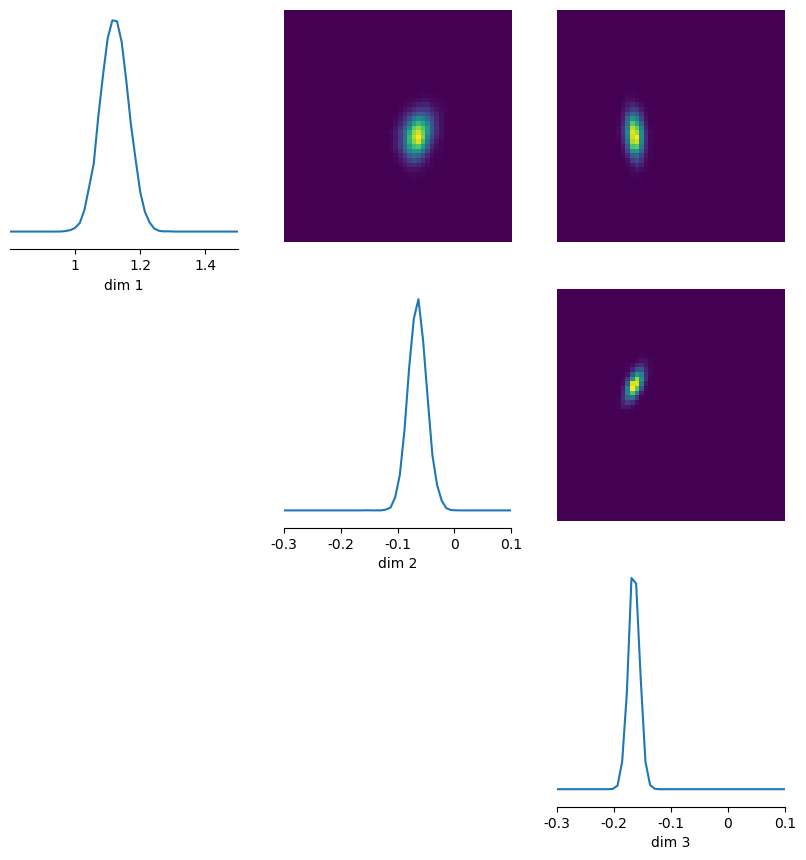

In [ ]:
limits = torch.stack([lower_limits_prior,upper_limits_prior]).T
fig, out = pairplot(samples.detach().cpu().numpy(), limits=limits,
                    labels=[r"$\beta_1$ : infection rate before T", r"$\beta_2 - \beta_1$ : change in infection rate after T", r"$\gamma - \beta_1$ : difference between recovery and infection rate"],
                    fig_kwargs={'fig_size':(3,3)},
                    upper='kde',
                    diag='kde')

## Sanity check

Let us now do a simple sanity check. We take the mean of the posterior parameter samples corresponding to each one of the models (with MSE and without MSE), simulate a data trajectory according to the mean values of the parameters, and compare it to the RKI data.

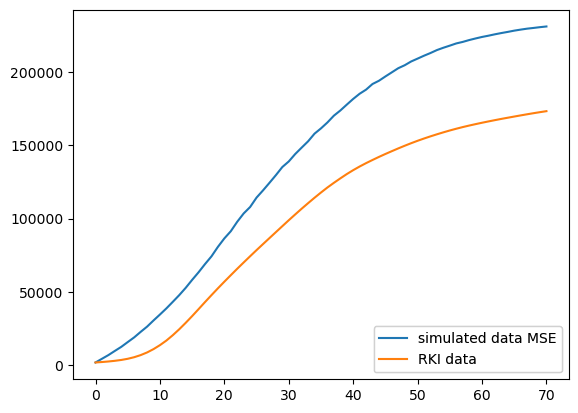

In [ ]:
import multiprocessing

samples_ave=torch.unsqueeze(torch.mean(samples,axis=0),0)
samples_ave=samples_ave.detach().cpu()

observation=simulator2(samples_ave)

fig,ax=plt.subplots()

line1,=ax.plot(observation.detach().cpu(),label="simulated data")
with multiprocessing.Pool() as pool:
    y_=[result for result in pool.map(simulator2, samples[:100])]

y_=torch.stack(y_)
y_=np.asarray(y_)

plt.plot(y_.T, "grey", zorder=0,alpha=0.2)

line2,=ax.plot(data.Confirmed[0:71],label="RKI data")
first_legend = ax.legend(handles=[line1,line2], loc='lower right')
ax.add_artist(first_legend)
plt.xlabel("Days")
plt.ylim(0,200000)
plt.ylabel("Confirmed cases")
plt.show()

## Sequential inference

Now let us see how our results change if we use sequential inference instead of the amortized one. We choose to do it in two rounds an use the same observation in both. As running 10000 simulations takes a fair amount of time, I recommend starting with 5000 (Spoiler: if you run 10000, this will significantly improe the fit)

Note, that given that we are running the simulations and network training on different devices, it gets a bit tricky with moving things around. 

Network training results in posterior distribution which is then in the second round of inference is used as a new prior distribution. Hence, before it is passed to the simulator (defined on the CPU), we have to move it from the GPU. We do it with auxiliary `inference1_cpu` object. Note, that `append_simulations` does not influence the corresponding class in connection to building the posterior distribution, and hence this move is justified.

In [ ]:
num_rounds = 2
# The specific observation we want to focus the inference on.

posteriors = []
proposal = prior_cpu
#inference = SNPE(prior=prior, density_estimator="nsf")
inference1=SNPE(prior=prior,device=device)
inference1_cpu=SNPE(prior=prior_cpu,device='cpu')
num_sims_sequential = int(num_sims/2.0)
for _ in range(num_rounds):
    #proposal=proposal.to('cpu')
    theta1, x1 = simulate_for_sbi(simulator2, proposal, num_simulations=num_sims_sequential,num_workers=-1)
    x1=x1.reshape((num_sims_sequential,71))
    x1=x1.to(torch.float32)
    # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator = inference1.append_simulations(
        theta1, x1, proposal=proposal
    ).train()
    density_estimator=density_estimator.to('cpu')
    #inference1=inference1.to('cpu')
    posterior1 = inference1_cpu.build_posterior(density_estimator)
    #posterior1=posterior1.to('cpu')
    proposal = posterior1.set_default_x(y_o)

/p/project/training2405/sc_venv_sbi_local/venv/lib/python3.11/site-packages/sbi/inference/base.py:177: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  self._device = process_device(device)
Running 10000 simulations in 10000 batches.: 100%|██████████| 10000/10000 [05:23<00:00, 30.87it/s]
/p/project/training2405/sc_venv_sbi_local/venv/lib/python3.11/site-packages/sbi/inference/snpe/snpe_base.py:150: UserWarning: Data x has device 'cpu'.Moving x to the data_device 'cuda'.Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/p/project/training2405/sc_venv_sbi_local/venv/lib/python3.11/site-packages/sbi/inference/snpe/snpe_base.py:150: UserWarning: Parameters theta has device 'cpu'. Moving theta to th

Using SNPE-C with atomic loss
 Neural network successfully converged after 66 epochs.

Drawing 10000 posterior samples: 10088it [00:00, 95507.12it/s]            
Running 10000 simulations in 10000 batches.: 100%|██████████| 10000/10000 [03:59<00:00, 41.74it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

The usual visualisation

Drawing 10000 posterior samples: 10099it [00:00, 90261.88it/s]                          
/tmp/ipykernel_11771/181097955.py:4: DeprecationWarning: **kwargs are deprecated, use fig_kwargs instead. 
               Calling the to be deprecated pairplot function
  fig, out = pairplot(samples, limits=[[0.8,1.5],[-0.3,0.1],[-0.3,0.1]], fig_size=(3,3), upper='kde', diag='kde')


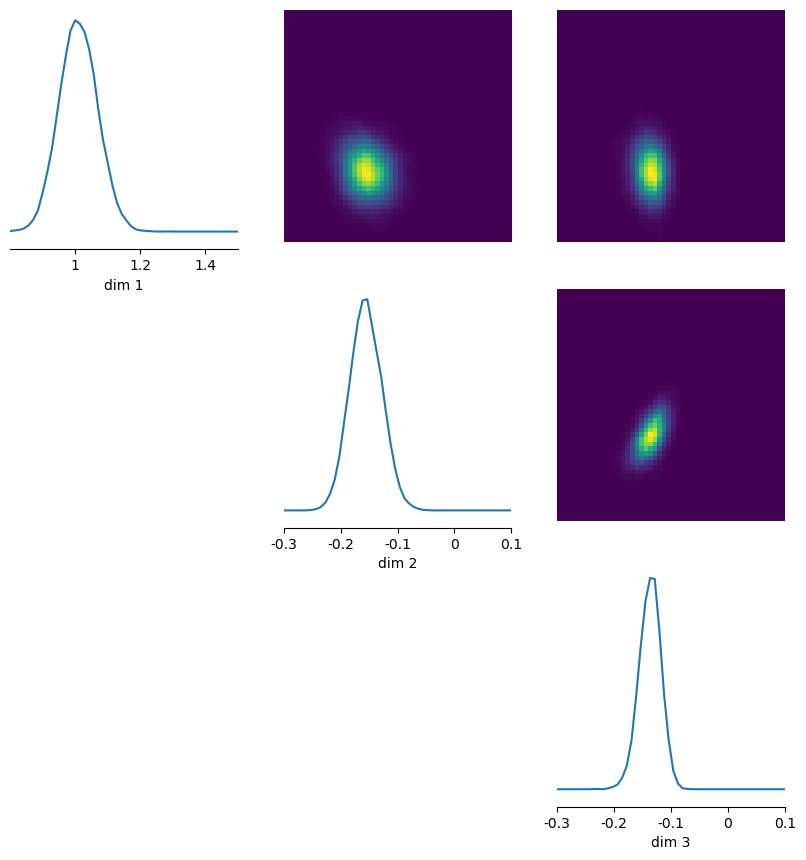

In [ ]:
samples_sequential = posterior1.sample((num_sims,), x=y_o)
fig, out = pairplot(samples_sequential.detach().cpu().numpy(), limits=limits,
                    labels=[r"$\beta_1$ : infection rate before T", r"$\beta_2 - \beta_1$ : change in infection rate after T", r"$\gamma - \beta_1$ : difference between recovery and infection rate"],
                    fig_kwargs={'fig_size':(3,3)},
                    upper='kde',
                    diag='kde')

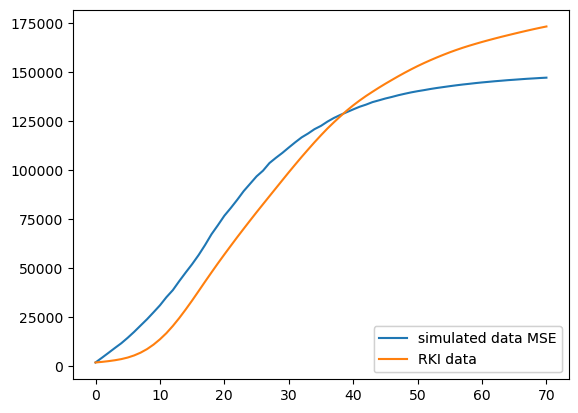

Process LokyProcess-78:
Process LokyProcess-74:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/p/software/jusuf/stages/2024/software/Python/3.11.3-GCCcore-12.3.0/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/p/software/jusuf/stages/2024/software/Python/3.11.3-GCCcore-12.3.0/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/p/software/jusuf/stages/2024/software/Python-bundle-PyPI/2023.06-GCCcore-12.3.0/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py", line 415, in _process_worker
    is_clean = worker_exit_lock.acquire(True, timeout=30)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
  File "/p/software/jusuf/stages/2024/software/Python/3.11.3-GCCcore-12.3.0/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/p/software/jusuf/stages/2024/software/Python/3.

In [ ]:
observation=simulator2(torch.unsqueeze(torch.mean(samples_sequential,axis=0),0))

fig,ax=plt.subplots()

line1,=ax.plot(observation,label="simulated data")
line3,=ax.plot(data.Confirmed[0:71],label="RKI data")
first_legend = ax.legend(handles=[line1,line3], loc='lower right')
ax.add_artist(first_legend)
plt.xlabel("Days")
plt.ylabel("Confirmed cases")
plt.show()

## learn from Summary Statistics

Now let us talk about summary statistic. Previously we have been extracting summary statistic from the simulation data without taking into the account the actual datapoint. However, this is clearly not forbidden!

Below we define a summary statistic which computes the mean squared error between the simulation output and the ground truth.

Note, that this kind of strategy can certainly work if you believe that all your datapoint correspond to a model with the same parameter values. However, if you want to run the SBI inference with the same prior on multiple datapoints, each one with possibly different parameter values, this approach may not work.

In [ ]:
x=x.reshape((num_sims,71))

y_truth=np.asarray(data.Confirmed)[:71]

def get_MSE_sim(x,y_t):
    x=np.asarray(x)
    y_t=y_t.reshape((1,y_t.shape[0]))
    return np.mean(np.square(x - y_t),axis=1,keepdims=True)

x_summary=get_MSE_sim(x,y_truth)

## Specifying and training the model

Here we define the model (SNPE in our case) and train the neural network

In [ ]:
x_summary=np.float32(x_summary)
x_summary=torch.from_numpy(x_summary).to(device)

inference=SNPE(prior)

_ = inference.append_simulations(theta, x_summary).train(training_batch_size=1000)

posterior = inference.build_posterior()

 Neural network successfully converged after 655 epochs.

## Incorporating the datapoint and visualising the results

Since we have already specified our datapoint when computing the summary statistic, in order to run the inference on the same data point we pass the variable `y_truth` as 0. We sample from the posterior and visualise the distributions of our parameters.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

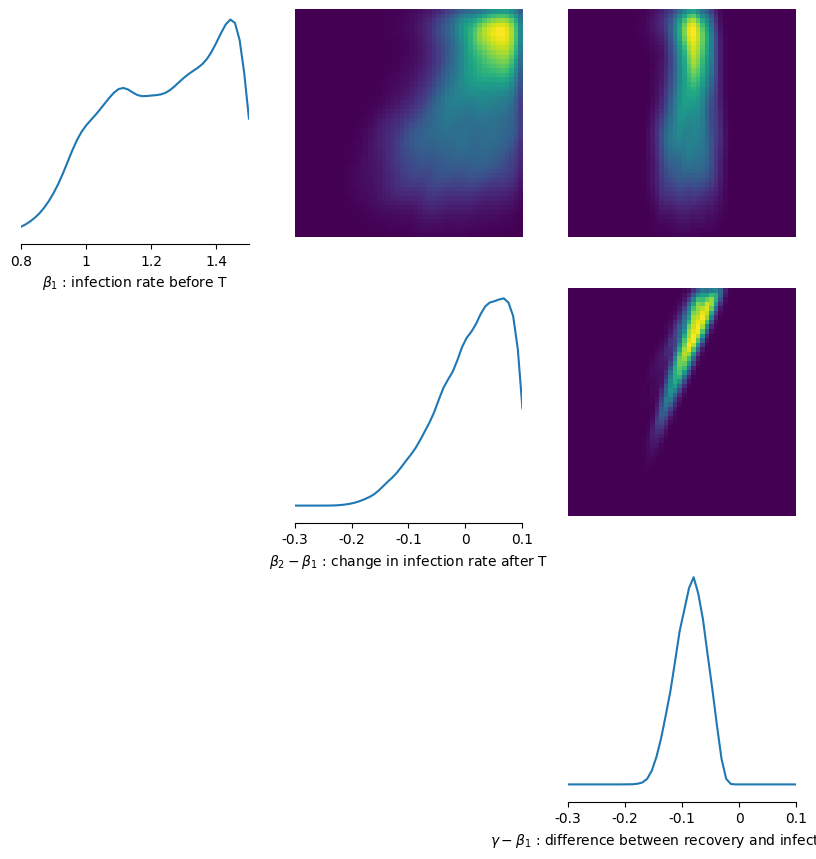

In [ ]:
y_truth= torch.as_tensor(
    [
        [
            0.0,
        ]
    ]
)



theta_p = posterior.sample((10000,), x=y_truth)

fig, out = pairplot(theta_p, 
                    limits=limits,
                    labels=[r"$\beta_1$ : infection rate before T", r"$\beta_2 - \beta_1$ : change in infection rate after T", r"$\gamma - \beta_1$ : difference between recovery and infection rate"],
                    fig_kwargs={'fig_size':(3,3)},
                    upper='kde',
                    diag='kde')

## Comparing the results

Let us now do a simple sanity check. We take the mean of the posterior parameter samples corresponding to each one of the models (with MSE and without MSE), simulate a data trajectory according to each one of them, and compare the to the RKI data.

Clearly the trajectory with summary statistic looks better. You can increase the numer of simulations and see whether this will improve the inference in any one of the cases.

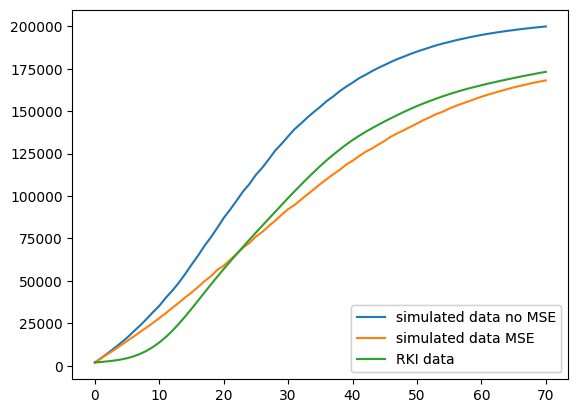

In [ ]:
observation1=simulator2(torch.unsqueeze(torch.mean(theta_p.detach().cpu(),axis=0),0))

fig,ax=plt.subplots()

line1,=ax.plot(observation,label="simulated data no MSE")
line2,=ax.plot(observation1,label="simulated data MSE")
line3,=ax.plot(data.Confirmed[0:71],label="RKI data")
first_legend = ax.legend(handles=[line1,line2,line3], loc='lower right')
ax.add_artist(first_legend)
plt.show()